# <center> Projet 6 : Classifiez automatiquement des biens de consommation
    Notebook Données images : CNN Transfer Learning

**Introduction**

Ce Notebook traite les images avec les méthodes classiques et de deep Learning avec classification non supervisée et classification supervisée.

Nous avons la mission suivante :

* Un algorithme de type CNN Transfer Learning peut éventuellement être utilisé.


# 1. Importation des modules et données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from os import listdir

from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans, AgglomerativeClustering

from keras.preprocessing import image
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, Activation
from keras.models import clone_model

from ipywidgets import IntProgress
from ipywidgets import Text
from IPython.display import display
from IPython.display import Image

from scipy.ndimage import gaussian_filter
from scipy.ndimage import median_filter
from PIL import Image as Image_PIL
import imageio
import imutils

import time
import os

In [2]:
pd.options.display.max_rows = 999

In [3]:
#upload images
image_path="C:\\Users\\Marwa\\Downloads\\Projet_6\\Dataset+projet+prétraitement+textes+images\\Flipkart\\Images"
images = [cv2.imread(file) for file in listdir(image_path)]
print(len(images))

1050


In [4]:
from IPython.display import Image

images_list =[Image(file) for file in listdir(image_path)]
len(images_list)

1050

In [5]:
data = pd.read_csv('C:\\Users\\Marwa\\Downloads\\Projet_6\\Dataset+projet+prétraitement+textes+images\\Flipkart\\flipkart_com-ecommerce_sample_1050.csv')

In [6]:
data.shape

(1050, 15)

# 2. Prétraitement des données visuelles

### Categories

In [7]:
data['product_category_tree'].nunique()

642

In [8]:
# Sample checking

data['product_category_tree'][100]

'["Beauty and Personal Care >> Makeup >> Vanity Boxes >> Goldencollections Vanity Boxes"]'

La variable product_category_tree est constituée de plusieurs sous-catégories de produits séparées par des chevrons.

Exemple : Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do...

In [9]:
#Traitement des catégories
def split_categories(category, level):
    '''Fonction qui affiche les '''
    category = category.split('["')[1].split('"]')[0]
    cat = category.split(' >> ')
    if(len(cat)) < 3:
        cat = [cat[0], cat[1], 'None']
        if(len(cat))<2:
            cat = [cat[0], 'None', 'None']
    return cat[level]

def split_categories_1(category):
    return split_categories(category,0)
def split_categories_2(category):
    return split_categories(category,1)
def split_categories_3(category):
    return split_categories(category,2)

def All_categories(dataframe):
    dataframe['cat_Niv_1'] = dataframe['product_category_tree'].apply(split_categories_1)
    dataframe['cat_Niv_2'] = dataframe['product_category_tree'].apply(split_categories_2)
    dataframe['cat_Niv_3'] = dataframe['product_category_tree'].apply(split_categories_3)
    return dataframe.drop(['product_category_tree'], axis=1)

In [10]:
data = All_categories(data)

In [11]:
data.groupby('cat_Niv_1').count()['uniq_id']

cat_Niv_1
Baby Care                     150
Beauty and Personal Care      150
Computers                     150
Home Decor & Festive Needs    150
Home Furnishing               150
Kitchen & Dining              150
Watches                       150
Name: uniq_id, dtype: int64

In [12]:
data['cat_Niv_1']
data['image']

0       55b85ea15a1536d46b7190ad6fff8ce7.jpg
1       7b72c92c2f6c40268628ec5f14c6d590.jpg
2       64d5d4a258243731dc7bbb1eef49ad74.jpg
3       d4684dcdc759dd9cdf41504698d737d8.jpg
4       6325b6870c54cd47be6ebfbffa620ec7.jpg
                        ...                 
1045    958f54f4c46b53c8a0a9b8167d9140bc.jpg
1046    fd6cbcc22efb6b761bd564c28928483c.jpg
1047    5912e037d12774bb73a2048f35a00009.jpg
1048    c3edc504d1b4f0ba6224fa53a43a7ad6.jpg
1049    f2f027ad6a6df617c9f125173da71e44.jpg
Name: image, Length: 1050, dtype: object

In [13]:
df_Pict=data[['cat_Niv_1','image']]

In [14]:
df_Pict['image']

0       55b85ea15a1536d46b7190ad6fff8ce7.jpg
1       7b72c92c2f6c40268628ec5f14c6d590.jpg
2       64d5d4a258243731dc7bbb1eef49ad74.jpg
3       d4684dcdc759dd9cdf41504698d737d8.jpg
4       6325b6870c54cd47be6ebfbffa620ec7.jpg
                        ...                 
1045    958f54f4c46b53c8a0a9b8167d9140bc.jpg
1046    fd6cbcc22efb6b761bd564c28928483c.jpg
1047    5912e037d12774bb73a2048f35a00009.jpg
1048    c3edc504d1b4f0ba6224fa53a43a7ad6.jpg
1049    f2f027ad6a6df617c9f125173da71e44.jpg
Name: image, Length: 1050, dtype: object

In [15]:
df_Pict=df_Pict.rename(columns = {'cat_Niv_1':'Category'})

In [16]:
df_Pict

,Category,image
0,Home Furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,Baby Care,7b72c92c2f6c40268628ec5f14c6d590.jpg
2,Baby Care,64d5d4a258243731dc7bbb1eef49ad74.jpg
3,Home Furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg
4,Home Furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg
...,...,...
1045,Baby Care,958f54f4c46b53c8a0a9b8167d9140bc.jpg
1046,Baby Care,fd6cbcc22efb6b761bd564c28928483c.jpg
1047,Baby Care,5912e037d12774bb73a2048f35a00009.jpg
1048,Baby Care,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg


## 3. CNN Transfer Learning

- Les réseaux de neurones convolutifs ont une méthodologie similaire à celle des méthodes traditionnelles d'apprentissage supervisé : ils reçoivent des images en entrée, détectent les features de chacune d'entre elles, puis entraînent un classifieur dessus.
- Les CNN réalisent eux-mêmes tout le boulot fastidieux d'extraction et description de features : lors de la phase d'entraînement, l'erreur de classification est minimisée afin d'optimiser les paramètres du classifieur ET les features.

### VGG16

- VGG-16 est une version du réseau de neurones convolutif VGG-Net.
- VGG-16 est constitué de plusieurs couches, dont 13 couches de convolution et 3 fully-connected. Il doit donc apprendre les poids de 16 couches.
- Il prend en entrée une image en couleurs de taille 224  × 224 px et la classifie dans une des 1000 classes. Il renvoie donc un vecteur de taille 1000, qui contient les probabilités d'appartenance à chacune des classes.

**Utilisation de VGG16 pré-entraîné sur ImageNet**

- Utilisation du modèle VGG16 pré-entraîné sur ImageNet (ImageNet est un projet de recherche visant à développer une grande base de données d'images avec des annotations, c'est-à-dire des images et leurs descriptions).

**ÉTAPE 1 - Chargement des images, extraction des features**

- Les images sont de tailles très inégales, il faudra les uniformiser en les redimensionnant pour pouvoir utiliser les réseaux de neurones et les CNN Transfert learning.
- Les tailles des images en entrées des réseaux de neurones sont 224 * 224, une partie du traitement des images sera de redimensionner en 224 * 224.

In [17]:
def preprocess_cnn(image, path=False):
    '''prétraitement des images'''
    
    #ouverture du fichier
    if path == False: #si on a fourni un array en entree :
        im = image
    else: #si on a fourni un chemin vers le fichier en entree:
        im = np.array(Image_PIL.open(image))
    
    #greyscale
    #im = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    
    #flou gaussien
    #im = gaussian_filter(im, sigma=2)
    
    #égalisation
    #im = cv2.equalizeHist(im)
    
    #Redimensionnement
    im =  cv2.resize(np.array(im), dsize=(224,224)) #ça change pas le nombre des pixels dans l'image
    
    return im

In [18]:
path = 'C:\\Users\\Marwa\\Downloads\\Projet_6\\Dataset+projet+prétraitement+textes+images\\Flipkart\\Images\\'

In [19]:
data['image_proces_cnn'] = data['image'].apply(lambda x: preprocess_cnn(os.path.join(path, x), path=True))

C:\Users\Marwa\anaconda3\lib\site-packages\PIL\Image.py:2855: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [20]:
# Utilisation de VGG16 pré-entraîné sur ImageNet avec les images d'origine
# VGG16 imports

# Liste
vgg16_all_features = []

# Instanciation du modèle
model_vgg16 = VGG16(weights='imagenet', include_top=False)
# Résumé de l'architecture du modèle
model_vgg16.summary()

for img in data['image_proces_cnn']:

    # Charger l'image et la redimensionner à la taille
    # requise de 224×224 pixels.
    #img = image.load_img(rep_image, target_size=(224, 224))
    # Convertir les pixels en un tableau NumPy afin de pouvoir travailler
    # avec dans Keras
    img = image.img_to_array(img)
    # Redimensionnement
    img = np.expand_dims(img, axis=0)
    # Préparer de nouvelles entrées pour le réseau.
    img = preprocess_input(img)

    # obtenir une prédiction de la probabilité d'appartenance
    # de l'image à chacun des 1000 types d'objets connus.
    vgg16_feature = model_vgg16.predict(img)
    # Ajouter la feature prédite en nparray à la liste
    vgg16_all_features.append(np.array(vgg16_feature).flatten())

vgg16_all_features = np.array(vgg16_all_features)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [21]:
data=data.rename(columns = {'cat_Niv_1':'Category'})

In [22]:
# Dataframe de sauvegarde des BOVW VGG16
# Association des features à chaque image
data['vgg16_bovw'] = [vgg16_all_features[i] for i in range(data.shape[0])]
# Dataframe de travail
df_vgg16_bovw = data[['image_proces_cnn', 'Category','vgg16_bovw']]
# Constituer le dataframe de vecteurs de BOVW VGG16
df_vgg16_vectors = pd.DataFrame.from_records(vgg16_all_features)

**ÉTAPE 2 - Réduction de dimension**

In [23]:
from sklearn.manifold import TSNE

In [24]:
type_donnee = 'TSNE_VGG16'

In [25]:
# t-SNE tuning du paramètre perplexity sans initialisation PCA
liste_param = [20, 30, 40, 50, 70, 80]
results_vgg16 = list()
tsne_results_vgg16 = []
for i in liste_param:
    tsne = TSNE(n_components=2, verbose=1, perplexity=i, n_iter=500,
                random_state=42)
    tsne_results_vgg16 = \
        tsne.fit_transform(df_vgg16_vectors)
    results_vgg16.append(tsne_results_vgg16)
print('t-SNE terminée!')

C:\Users\Marwa\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Marwa\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.029s...
[t-SNE] Computed neighbors for 1050 samples in 0.397s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 445.494025
[t-SNE] KL divergence after 250 iterations with early exaggeration: 123.609711
[t-SNE] KL divergence after 500 iterations: 2.678797


C:\Users\Marwa\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Marwa\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.031s...
[t-SNE] Computed neighbors for 1050 samples in 0.433s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 474.849630
[t-SNE] KL divergence after 250 iterations with early exaggeration: 115.363197
[t-SNE] KL divergence after 500 iterations: 2.136731


C:\Users\Marwa\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Marwa\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.040s...
[t-SNE] Computed neighbors for 1050 samples in 0.457s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 497.297886
[t-SNE] KL divergence after 250 iterations with early exaggeration: 115.569916
[t-SNE] KL divergence after 500 iterations: 1.765054
[t-SNE] Computing 151 nearest neighbors...


C:\Users\Marwa\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Marwa\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Indexed 1050 samples in 0.030s...
[t-SNE] Computed neighbors for 1050 samples in 0.489s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 515.735452
[t-SNE] KL divergence after 250 iterations with early exaggeration: 110.030174
[t-SNE] KL divergence after 500 iterations: 2.225106


C:\Users\Marwa\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Marwa\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.032s...
[t-SNE] Computed neighbors for 1050 samples in 0.363s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 545.992474
[t-SNE] KL divergence after 250 iterations with early exaggeration: 105.808487
[t-SNE] KL divergence after 500 iterations: 1.487207
[t-SNE] Computing 241 nearest neighbors...


C:\Users\Marwa\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Marwa\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Indexed 1050 samples in 0.037s...
[t-SNE] Computed neighbors for 1050 samples in 0.368s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 559.185995
[t-SNE] KL divergence after 250 iterations with early exaggeration: 98.609337
[t-SNE] KL divergence after 500 iterations: 1.360894
t-SNE terminée!


In [26]:
def affiche_tsne(results_list, liste_param, alpha=0.1):
    i = 0

    # Visualisation en 2D des différents résultats selon la perplexité
    plt.subplots(3, 2, figsize=[15, 20])

    for resultat_tsne in results_list:

        # Perplexité=5
        plt.subplot(3, 2, i + 1)
        tsne_results_i = results_list[i]
        sns.scatterplot(x=tsne_results_i[:, 0], y=tsne_results_i[:, 1],
                        alpha=alpha)
        plt.title('t-SNE avec perplexité=' + str(liste_param[i]))
        plt.grid(False)
        plt.plot()

        i += 1

    plt.show()


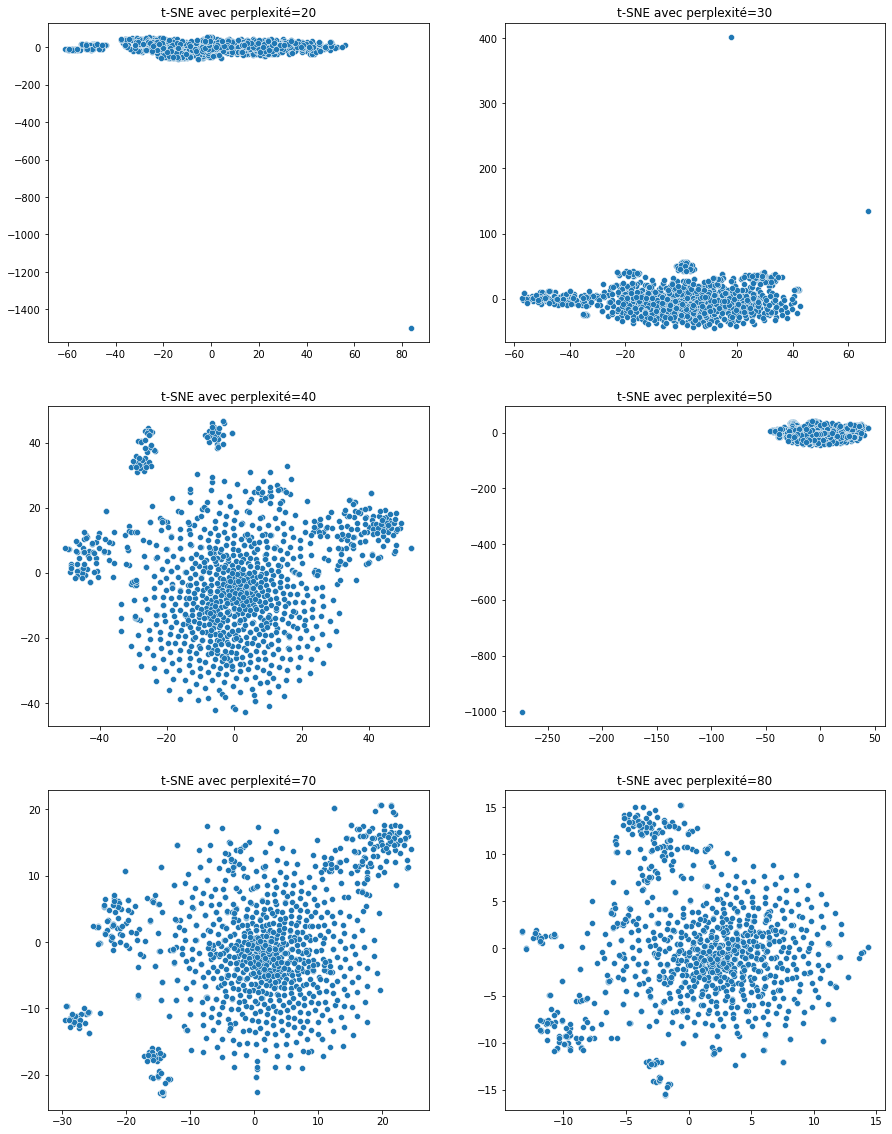

In [27]:
affiche_tsne(results_vgg16, liste_param, 1)

- groupes plus homogènes pour perplexité=80
- on laissera les paramètres learning_rate et n_iter à 5000 et le nombre de composants par défaut (2).

In [28]:
# Réduction de dimension tsne
tsne_vgg16 = TSNE(verbose=1, perplexity=40, n_iter=5000)
X_proj_tsne_vgg16 = \
    tsne_vgg16.fit_transform(df_vgg16_vectors)
# Dataframe pour clustering
df_tsne_vgg16 = pd.DataFrame({'VAR1' : X_proj_tsne_vgg16[:, 0],
                              'VAR2' : X_proj_tsne_vgg16[:, 1],
                              'Category': df_vgg16_bovw['Category'],
                              'IMAGE': df_vgg16_bovw['image_proces_cnn']})

C:\Users\Marwa\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Marwa\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.028s...
[t-SNE] Computed neighbors for 1050 samples in 0.332s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 497.297886
[t-SNE] KL divergence after 250 iterations with early exaggeration: 114.532967
[t-SNE] KL divergence after 4050 iterations: 1.685241


In [47]:
# from sklearn import manifold, decomposition

# print("Dimensions avant PCA :", vgg16_all_features.shape)
# pca= decomposition.PCA(n_components=0.99)
# pca_feat= pca.fit_transform(vgg16_all_features)
# print("Dimensions après PCA :", pca_feat.shape)

Dimensions avant PCA : (1050, 25088)
Dimensions après PCA : (1050, 939)


**ÉTAPE 3 - Clustering**

In [29]:
cols = ['VAR1', 'VAR2']

In [30]:
# Instanciation du modèle KMeans avec les meilleurs paramètres
kmeans_tsne_vgg16 = KMeans(n_clusters=7, init='k-means++',
                           n_init=10, max_iter=200,
                           random_state=42) \
    .fit(df_tsne_vgg16[cols])
# Ajout de l'assignation du cluster au dataframe
df_tsne_vgg16['Clusters'] = kmeans_tsne_vgg16.labels_
kmeans_tsne_vgg16_labels = kmeans_tsne_vgg16.labels_

In [31]:
from sklearn import cluster, metrics

In [32]:
labels = df_Pict["Category"]
print("ARI : ", metrics.adjusted_rand_score(labels, kmeans_tsne_vgg16.labels_))

ARI :  0.3433746970667091


**ÉTAPE 4 - Visualisation des clusters**

In [33]:
def affiche_projection_par_clusters(X_projected, clusters_labels, titre):

    plt.figure(figsize=[25, 15])

    sns.scatterplot(X_projected[:, 0], X_projected[:, 1],
                    hue=clusters_labels, s=100, alpha=1, palette='Set1')

    plt.title(titre, fontsize=40)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=34)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.grid(False)
    plt.show()

C:\Users\Marwa\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


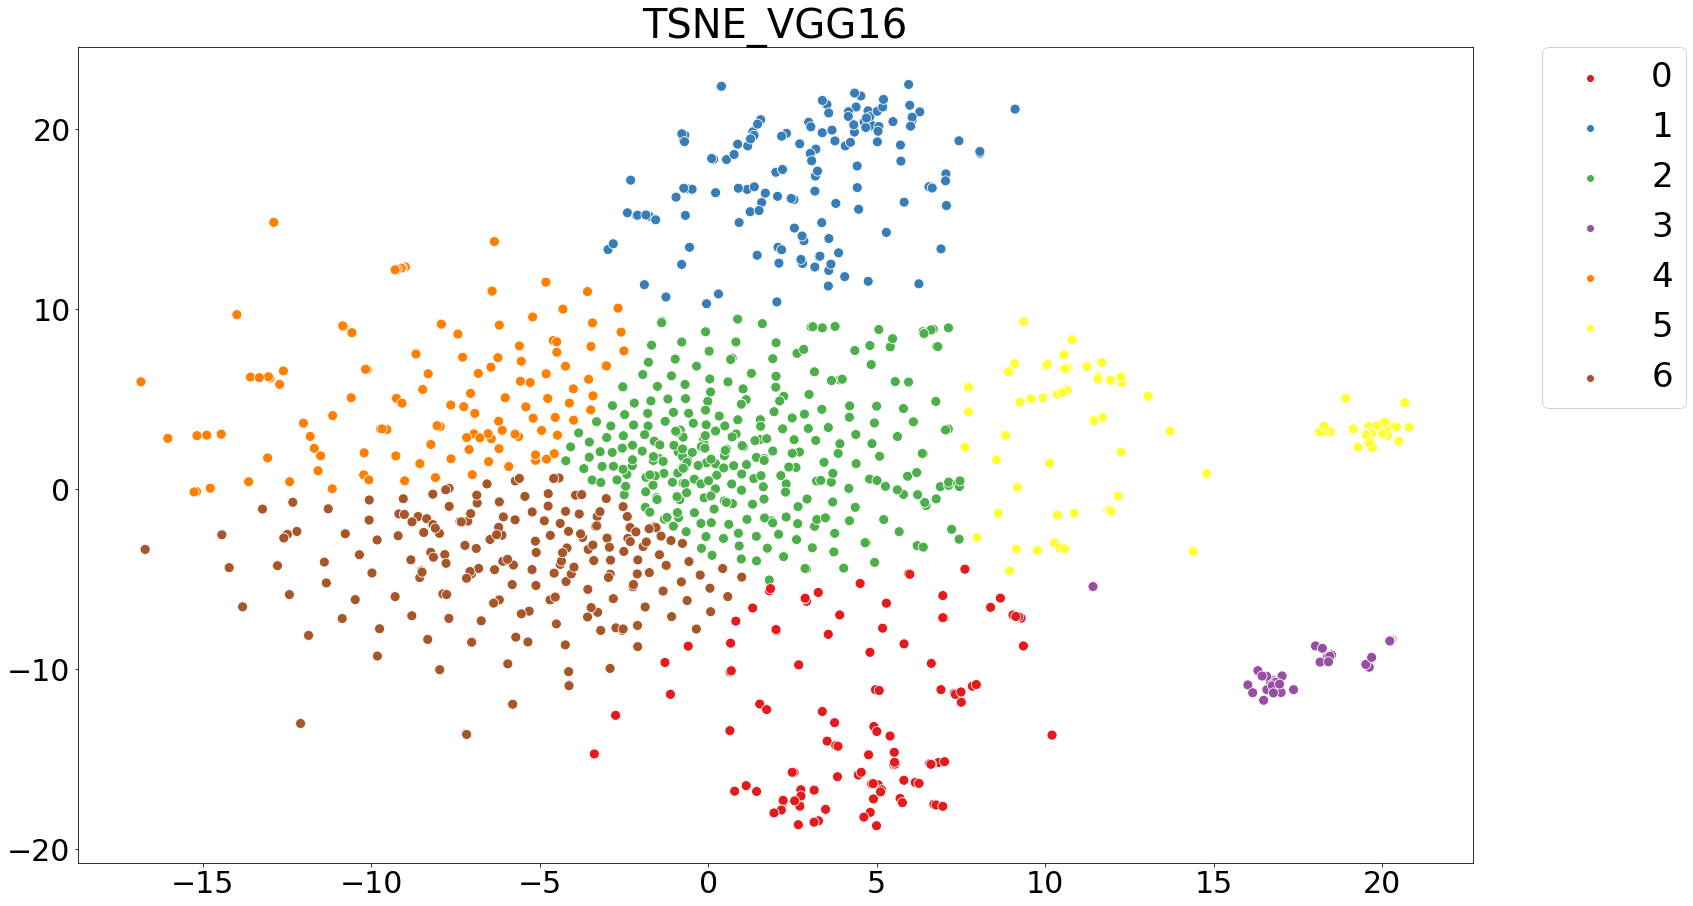

In [34]:
# Visualisation des clusters
affiche_projection_par_clusters(X_proj_tsne_vgg16,
                                           kmeans_tsne_vgg16_labels,
                                           type_donnee)

**Bilan** :
***
- Le score ARI est  (0.33).
- Cette combinaison TSNE VGG16 sur les images parvient à retrouver les 7 catégories comme le souhaite notre client 

**ÉTAPE 5 - Qualité de catégorisation**

In [35]:
def traduire_valeurs_variable(dataframe, colonne_a_traduire, dictionnaire):
   
    for cle, valeur in dictionnaire.items():
        dataframe[colonne_a_traduire] = dataframe[colonne_a_traduire].replace(
            cle, valeur)

In [36]:
from sklearn.metrics import confusion_matrix

In [37]:
from IPython.display import Markdown

In [38]:
from sklearn.metrics import classification_report

In [39]:
def affiche_qualite_categorisation(dataframe, dico_traduction, titre):

    dataframe['Cluster_labels'] = dataframe['Clusters'].copy().astype('str')
    traduire_valeurs_variable(dataframe, 'Cluster_labels',
                                          dico_traduction)

    cat_pred = dataframe['Category']
    cat_reel = dataframe['Cluster_labels']

    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(cat_reel, cat_pred),
                annot=True,
                fmt='d',
                cbar=False,
                cmap='Blues',
                yticklabels=sorted(cat_pred.unique()))
    plt.title(titre)
    plt.show()

    display(
        'Précision: {}%'.format(
            round(
                accuracy_score(
                    cat_pred,
                    cat_reel) *
                100,
                2)))
    display(Markdown(classification_report(cat_reel, cat_pred)))

La matrice de confusion doit être transformée pour mettre avoir en colonne le même ordre des catégories supposées qu'en ligne

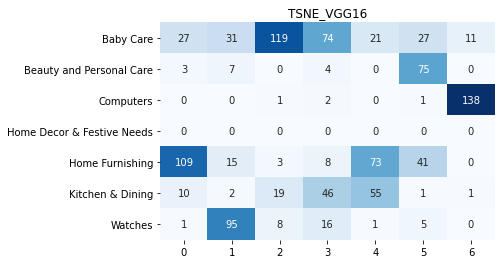

'Précision: 10.38%'

C:\Users\Marwa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Marwa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Marwa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

                 Baby Care       0.18      0.09      0.12       310
  Beauty and Personal Care       0.05      0.08      0.06        89
                 Computers       0.01      0.01      0.01       142
Home Decor & Festive Needs       0.00      0.00      0.00         0
           Home Furnishing       0.49      0.29      0.37       249
          Kitchen & Dining       0.01      0.01      0.01       134
                   Watches       0.00      0.00      0.00       126

                  accuracy                           0.10      1050
                 macro avg       0.10      0.07      0.08      1050
              weighted avg       0.17      0.10      0.13      1050


In [40]:
dico_categories = {'0': 'Watches',
                   '1': 'Computers',
                   '2': 'Baby Care',
                   '3': 'Home Furnishing',
                   '4': 'Kitchen & Dining',
                   '5': 'Beauty and Personal Care',
                   '6': 'Home Furnishing'}
affiche_qualite_categorisation(df_tsne_vgg16,
                                          dico_categories, type_donnee)

# Conclusion

- Le modèle CNN donne des meilleurs résulats comparé au SIFT sur le traitement des données visuelles.

- Validation de la faisabilité du projet de classification automatique non-supervisé :

    - Possibilité d’atteindre un ARI jusqu’à 0,54 entre clusters et catégories vraies
    - Soit 483 articles mal catégorisés sur 1050

- La faisabilité de la classification automatique peut être amenée à changer si :

    - La qualité des descriptions ou des images changeait
    - Le nombre de catégories des produits se multiplient

- Si les catégories ne sont pas amenées à évoluer, possibilité d’effectuer une classification supervisée à partir des 1050 articles disponibles